<a href="https://colab.research.google.com/github/kennethmugo/Swahili-SMS-Spam-Detection/blob/main/research/topic_modeling_swahili_spam_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from openai import OpenAI
import pandas as pd
import numpy as np
from tqdm import tqdm
import kagglehub
from sentence_transformers import SentenceTransformer

In [7]:
## Download the dataset from kaggle
path = kagglehub.dataset_download("henrydioniz/swahili-sms-detection-dataset")
full_path = os.path.join(path, "bongo_scam.csv")
df = pd.read_csv(full_path)
df = df.drop_duplicates()
df.head()

,Category,Sms
0,trust,"Nipigie baada ya saa moja, tafadhali."
1,scam,Naomba unitumie iyo Hela kwenye namba hii ya A...
2,scam,"666,KARIBU FREEMASON UTIMIZE NDOTO KATIKA BIAS..."
3,trust,Watoto wanapenda sana zawadi ulizowaletea.
4,scam,IYO PESA ITUME KWENYE NAMBA HII 0657538690 JIN...


In a previous notebook, we found that GPT models understood the swahili language the best. Thus, we're going to use the explanations from the model for scam messages in particular to see the common topics we can find in those messages.

In [9]:
## Filter the spam messages only.
df = df[df["Category"] == "scam"]
df.head()

,Category,Sms
1,scam,Naomba unitumie iyo Hela kwenye namba hii ya A...
2,scam,"666,KARIBU FREEMASON UTIMIZE NDOTO KATIKA BIAS..."
4,scam,IYO PESA ITUME KWENYE NAMBA HII 0657538690 JIN...
5,scam,Iyo pesa itume humu kwenye AIRTEL 0696530433 j...
7,scam,Xorry nipo xafari nina xhida kwel nakuomba uni...


In [11]:
# Initialize the OpenAI client with your API key
from google.colab import userdata
client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))

We'll now use `GPT-4.1` model provided by OpenAI to get explanations for why the messages are considered as scam. These explanations will then be used to build our topics.

In [12]:
def explain_message(message: str, model="gpt-4.1-2025-04-14"):
    system_prompt = (
        "You are a spam classifier."
        "The message may contain Swahili, English, or both, and may include misspellings. "
        "Explain why the message is classified as spam. Your response should only return the explanation."
    )

    user_prompt = f"Message: \"{message}\""

    response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt},
            ],
            temperature=0.2,
        )

    reply = response.choices[0].message.content.strip()
    return reply

In [13]:
message = "HELLO. Ungana na wakenya wengi wanoSHINDA katika PICK A BOX.2024 END YEAR Bonus NI from 50,000. BONYEZA *201# BILA Credo upick BOX YAKO.STOP *456*9*5#"
response = explain_message(message)
print(response)

This message is classified as spam because it uses promotional language to entice recipients with the promise of winning a large cash bonus ("END YEAR Bonus NI from 50,000") through a game ("PICK A BOX"). It encourages immediate action by instructing the recipient to dial a USSD code ("BONYEZA *201#") and emphasizes that no airtime is needed ("BILA Credo"), which is a common tactic in mobile-based scams. The message also includes an opt-out code ("STOP *456*9*5#"), which is typical in unsolicited bulk messages. The overall structure, urgency, and promise of easy winnings are characteristic of spam and potential phishing attempts.


In [14]:
## Now let us get explanations from GPT-4.1 for the spam messages.
messages = df['Sms'].tolist()
model_explanations = []

for i in tqdm(range(len(messages)), desc="Getting explanations for spam messages..."):
  message = messages[i]
  explanation = explain_message(message)
  model_explanations.append(explanation)

df['Explanation'] = model_explanations
df.head()

Getting explanations for spam messages...: 100%|██████████| 880/880 [29:34<00:00,  2.02s/it]


,Category,Sms,Explanation
1,scam,Naomba unitumie iyo Hela kwenye namba hii ya A...,This message is classified as spam because it ...
2,scam,"666,KARIBU FREEMASON UTIMIZE NDOTO KATIKA BIAS...",The message is classified as spam because it p...
4,scam,IYO PESA ITUME KWENYE NAMBA HII 0657538690 JIN...,This message is classified as spam because it ...
5,scam,Iyo pesa itume humu kwenye AIRTEL 0696530433 j...,This message is classified as spam because it ...
7,scam,Xorry nipo xafari nina xhida kwel nakuomba uni...,This message is classified as spam because it ...


Now let us go through a common pipeline for text clustering.

### 1. Embedding Documents
Since the explanations may contain English and Swahili words, we'll use the LaBSE embedding model which worked great with our Logistics Regression classifier.

In [202]:
# Create an embedding for each abstract
embedding_model = SentenceTransformer('sentence-transformers/LaBSE')
embeddings = embedding_model.encode(model_explanations, show_progress_bar=True)

In [16]:
# Check the dimensions of the resulting embeddings
embeddings.shape

(880, 768)

### 2. Reducing the Dimensionality of Embeddings

In [17]:
from umap import UMAP

# We reduce the input embeddings from 768 dimenions to 5 dimenions
umap_model = UMAP(
    n_components=5, min_dist=0.0, metric='cosine', random_state=42
)
reduced_embeddings = umap_model.fit_transform(embeddings)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### 3. Cluster the Reduced Embeddings

We can cluster the documents with `HDBSCAN`. `HDBSCAN` is a density-based algorithm that works quite well with `UMAP` since `UMAP` maintains a lot of local structure even in lower-dimensional space. Moreover, `HDBSCAN` does not force data points to clusters as it considers them outliers.

In [189]:
from hdbscan import HDBSCAN

# We fit the model and extract the clusters
hdbscan_model = HDBSCAN(
    min_cluster_size=50, metric='euclidean', cluster_selection_method='eom'
).fit(reduced_embeddings)
clusters = hdbscan_model.labels_

# How many clusters did we generate?
len(set(clusters))

6

### Inspecting the Clusters

Manually inspect the first three documents in cluster 0:

In [190]:
import numpy as np

# Print first three documents in cluster 0
cluster = 0
for index in np.where(clusters==cluster)[0][:3]:
    print(model_explanations[index] + "\n")

This message is classified as spam because it claims the recipient has won a large sum of money (Sh170,000 milioni) from "Tuzo point" and instructs them to call a phone number to claim the prize. Such messages are common tactics used in scams to lure recipients into providing personal information or paying fees. The message uses enticing language, lacks official branding, and contains grammatical errors, all of which are typical characteristics of spam and fraudulent messages.

This message is classified as spam because it claims the recipient has won a large sum of money (Tsh10,000,000) and instructs them to call a specific phone number to claim the prize. Such messages are common tactics used in phishing and lottery scams to trick individuals into sharing personal information or sending money. The message uses urgency and the promise of a reward to entice the recipient, which are typical characteristics of spam and fraudulent messages.

This message is classified as spam because it c

Next, we reduce our embeddings to 2-dimensions so that we can plot them and get a rough understanding of the generated clusters.

In [191]:
import pandas as pd

# Reduce 384-dimensional embeddings to 2 dimensions for easier visualization
reduced_embeddings = UMAP(
    n_components=2, min_dist=0.0, metric='cosine', random_state=42
).fit_transform(embeddings)

# Create dataframe
explanations_df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
explanations_df["explanation"] = model_explanations
explanations_df["cluster"] = [str(c) for c in clusters]
explanations_df["text"] = messages

# Select outliers and non-outliers (clusters)
clusters_df = explanations_df.loc[explanations_df.cluster != "-1", :]
outliers_df = explanations_df.loc[explanations_df.cluster == "-1", :]

### Static Plot

(np.float64(-9.771141624450683),
 np.float64(27.606773948669435),
 np.float64(-14.603896284103394),
 np.float64(19.62256255149841))

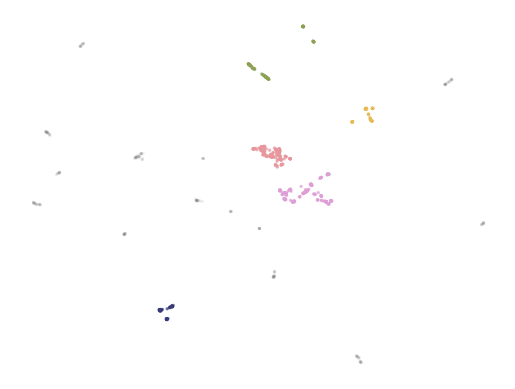

In [192]:
import matplotlib.pyplot as plt

# Plot outliers and non-outliers seperately
plt.scatter(outliers_df.x, outliers_df.y, alpha=0.05, s=2, c="grey")
plt.scatter(
    clusters_df.x, clusters_df.y, c=clusters_df.cluster.astype(int),
    alpha=0.6, s=2, cmap='tab20b'
)
plt.axis('off')

## From Text Clustering to Topic Modeling
### BERTopic: A Modular Topic Modeling Framework

In [32]:
%%capture
!pip install bertopic datamapplot

In [193]:
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired

representation_model = KeyBERTInspired()

# Train our model with our previously defined models
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    #representation_model = representation_model,
    verbose=True
).fit(model_explanations, embeddings)

2025-06-05 14:27:36,253 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-05 14:27:40,015 - BERTopic - Dimensionality - Completed ✓
2025-06-05 14:27:40,017 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-05 14:27:40,059 - BERTopic - Cluster - Completed ✓
2025-06-05 14:27:40,068 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-05 14:27:40,152 - BERTopic - Representation - Completed ✓


Now, let's start exploring the topics that we got by running the code above.

In [194]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,301,-1_to_the_and_is,"[to, the, and, is, spam, message, money, or, it, phone]","[This message is classified as spam because it requests the recipient to send money via M-Pesa to a specific phone number and provides a name for verification. Such messages are commonly used in financial scams to trick individuals into sending money to fraudsters. The message does not provide any legitimate context or reason for the payment, which is a typical characteristic of spam and scam attempts., This message is classified as spam because it requests the recipient to send money via AirtelMoney to a specific phone number and provides a name for verification. Such messages are commonly used in financial scams to trick individuals into sending money to fraudsters. The message does not provide any legitimate context or reason for the request, which is a typical characteristic of spam and phishing attempts., This message is classified as spam because it requests the recipient to send money via M-Pesa to a specific phone number and provides a name for confirmation. Such messages are commonly used in phishing and financial scams to trick individuals into sending money to fraudsters. The message does not provide any legitimate context or reason for the payment, which is a typical characteristic of spam and scam attempts.]"
1,0,152,0_the_is_message_to,"[the, is, message, to, and, money, it, reason, legitimate, context]","[This message is classified as spam because it requests the recipient to send money to a specific phone number and provides a name, which is a common tactic used in financial scams. The message does not provide any context or legitimate reason for the money transfer, making it suspicious and likely to be fraudulent., This message is classified as spam because it requests the recipient to send money to a specific phone number and provides a name, which is a common tactic used in financial scams and phishing attempts. The message does not provide any legitimate context or reason for the money transfer, making it suspicious and likely to be fraudulent., This message is classified as spam because it requests the recipient to send money to a specific phone number and provides a name, which is a common tactic used in financial scams. The message does not provide any legitimate context or reason for the money request, making it suspicious and likely to be fraudulent.]"
2,1,135,1_to_the_money_number,"[to, the, money, number, is, and, for, name, message, recipient]","[This message is classified as spam because it requests the recipient to send money to a specific phone number and provides a name for the transaction. Such messages are common in financial scams, where fraudsters attempt to trick individuals into sending money under false pretenses. The message does not provide any legitimate context or reason for the request, which is a typical characteristic of spam and scam attempts., This message is classified as spam because it requests the recipient to send money to a specific mobile number and provides a name for the transaction. Such messages are commonly used in financial scams and phishing attempts to trick individuals into transferring funds to fraudsters. The message does not provide any legitimate context or reason for the money request, which is a typical characteristic of spam., This message is classified as spam because it requests the recipient to send money to a specific mobile number and provides a name for confirmation. Such messages are commonly used in phishing and financial scams to trick individuals into sending money to fraudsters. The message does not provide any legitimate context or reason for the money transfer, which is a typical characteristic of spam and scam attempts.]"
3,2,97,2_is_link_it_job,"[is, link, it, job, which, details, message, whatsapp, the, 000]","[This message is classified as spam because it promises easy money (""earn 170,000TZS a day"") wi

In [195]:
topic_model.get_topic(0)

[('the', np.float64(0.08264066581401967)),
 ('is', np.float64(0.06990998637854813)),
 ('message', np.float64(0.06868715610677381)),
 ('to', np.float64(0.06687713875905935)),
 ('and', np.float64(0.06331114568670168)),
 ('money', np.float64(0.06279796606900084)),
 ('it', np.float64(0.06206753389722865)),
 ('reason', np.float64(0.06037363141061149)),
 ('legitimate', np.float64(0.059333559515267115)),
 ('context', np.float64(0.057110737702782126))]

In [196]:
# Visualize topics and documents
fig = topic_model.visualize_documents(
    model_explanations,
    reduced_embeddings=reduced_embeddings,
    width=1200,
    hide_annotations=True
)

# Update fonts of legend for easier visualization
fig.update_layout(font=dict(size=16))

In [197]:
# Visualize barchart with ranked keywords
topics_count = len(set(clusters))
topic_model.visualize_barchart(top_n_topics=topics_count, n_words=7)

# Visualize relationships between topics
#topic_model.visualize_heatmap()

# Visualize the potential hierarchical structure of topics
#topic_model.visualize_hierarchy()

Seems like topics 0 and 1 mainly relate to money scams. Topic 2 seems to include a lot of phishing attempts via links in messages. Topic 3 seems to be dominated by traditional healing advertising messages. Topic 4 seems to be domunated by messages telling users they've won prize rewards of significant amounts.

Topic 5 isn't really clear and maybe an indication that we may have an additional cluster that probably shouldn't exist.